#**Install Dependencies and Bring in Data**

---

In [1]:
import os
import pandas as pd
import tensorflow as tf
import numpy as np

In [2]:
df = pd.read_csv('/content/drive/MyDrive/Machine Learning /train.csv/train.csv')

In [3]:
df.head()

id                                       comment_text  toxic  \
0  0000997932d777bf  Explanation\nWhy the edits made under my usern...      0   
1  000103f0d9cfb60f  D'aww! He matches this background colour I'm s...      0   
2  000113f07ec002fd  Hey man, I'm really not trying to edit war. It...      0   
3  0001b41b1c6bb37e  "\nMore\nI can't make any real suggestions on ...      0   
4  0001d958c54c6e35  You, sir, are my hero. Any chance you remember...      0   

   severe_toxic  obscene  threat  insult  identity_hate  
0             0        0       0       0              0  
1             0        0       0       0              0  
2             0        0       0       0              0  
3             0        0       0       0              0  
4             0        0       0       0              0

# **Preprocess**
---

In [4]:
from tensorflow.keras.layers import TextVectorization

In [5]:
X = df['comment_text']
y = df[df.columns[2:]].values

In [6]:
MAX_FEATURES = 200000 # number of words in the vocab

In [7]:
vectorizer = TextVectorization(max_tokens=MAX_FEATURES,
                               output_sequence_length=1800,
                               output_mode='int')

In [8]:
vectorizer.adapt(X.values)

In [9]:
vectorized_text = vectorizer(X.values)

In [10]:
#MCSHBAP - map, chache, shuffle, batch, prefetch  from_tensor_slices, list_file
dataset = tf.data.Dataset.from_tensor_slices((vectorized_text, y))
dataset = dataset.cache()
dataset = dataset.shuffle(160000)
dataset = dataset.batch(16)
dataset = dataset.prefetch(8) # helps bottlenecks

In [11]:
train = dataset.take(int(len(dataset)*.7))
val = dataset.skip(int(len(dataset)*.7)).take(int(len(dataset)*.2))
test = dataset.skip(int(len(dataset)*.9)).take(int(len(dataset)*.1))

# **Create Sequential Model**
___

In [12]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Bidirectional, Dense, Embedding

In [13]:
model = Sequential()
# Create the embedding layer 
model.add(Embedding(MAX_FEATURES+1, 32))
# Bidirectional LSTM Layer
model.add(Bidirectional(LSTM(32, activation='tanh')))
# Feature extractor Fully connected layers
model.add(Dense(128, activation='relu'))
model.add(Dense(256, activation='relu'))
model.add(Dense(128, activation='relu'))
# Final layer 
model.add(Dense(6, activation='sigmoid'))

In [14]:
model.compile(loss='BinaryCrossentropy', optimizer='Adam')

In [15]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 32)          6400032   
                                                                 
 bidirectional (Bidirectiona  (None, 64)               16640     
 l)                                                              
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dense_1 (Dense)             (None, 256)               33024     
                                                                 
 dense_2 (Dense)             (None, 128)               32896     
                                                                 
 dense_3 (Dense)             (None, 6)                 774       
                                                        

In [21]:
history = model.fit(train, epochs=10, validation_data=val)

Epoch 1/10
6981/6981 [==============================] - 615s 88ms/step - loss: 0.0456 - val_loss: 0.0425
Epoch 2/10
6981/6981 [==============================] - 600s 86ms/step - loss: 0.0403 - val_loss: 0.0371
Epoch 3/10
6981/6981 [==============================] - 598s 86ms/step - loss: 0.0358 - val_loss: 0.0319
Epoch 4/10
6981/6981 [==============================] - 590s 85ms/step - loss: 0.0319 - val_loss: 0.0272
Epoch 5/10
6981/6981 [==============================] - 600s 86ms/step - loss: 0.0294 - val_loss: 0.0259
Epoch 6/10
6981/6981 [==============================] - 608s 87ms/step - loss: 0.0259 - val_loss: 0.0227
Epoch 7/10
6981/6981 [==============================] - 594s 85ms/step - loss: 0.0237 - val_loss: 0.0216
Epoch 8/10
6981/6981 [==============================] - 598s 86ms/step - loss: 0.0213 - val_loss: 0.0171
Epoch 9/10
6981/6981 [==============================] - 602s 86ms/step - loss: 0.0191 - val_loss: 0.0167
Epoch 10/10
6981/6981 [==============================] 

In [23]:
from matplotlib import pyplot as plt

<Figure size 800x500 with 0 Axes>

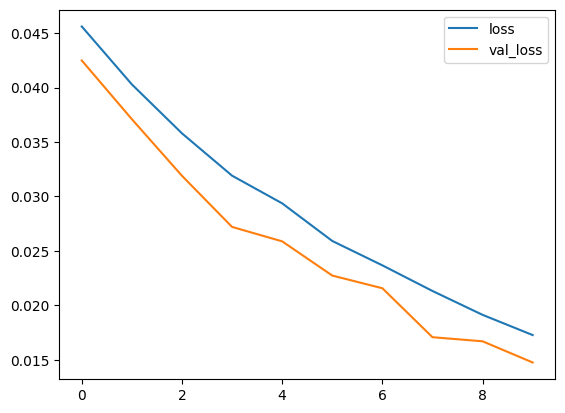

In [24]:
plt.figure(figsize=(8,5))
pd.DataFrame(history.history).plot()
plt.show()

# **Make Predictions**

In [27]:
input_text = vectorizer('You freaking suck! I am going to kill you.')

In [32]:
res = model.predict(np.expand_dims(input_text,0))

1/1 [==============================] - 0s 52ms/step


In [29]:
batch = test.as_numpy_iterator().next()

In [30]:
batch_X, batch_Y = test.as_numpy_iterator().next()

In [31]:
(model.predict(batch_X) > 0.5).astype(int)

1/1 [==============================] - 0s 70ms/step


array([[0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 1, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 1, 0],
       [0, 0, 0, 0, 0, 0]])

In [34]:
res.shape

(1, 6)

# **Evaluate Model**

In [35]:
from tensorflow.keras.metrics import Precision, Recall, CategoricalAccuracy

In [36]:
pre = Precision()
re = Recall()
acc = CategoricalAccuracy()

In [37]:
for batch in test.as_numpy_iterator(): 
    # Unpack the batch 
    X_true, y_true = batch
    # Make a prediction 
    yhat = model.predict(X_true)
    
    # Flatten the predictions
    y_true = y_true.flatten()
    yhat = yhat.flatten()
    
    pre.update_state(y_true, yhat)
    re.update_state(y_true, yhat)
    acc.update_state(y_true, yhat)

1/1 [==============================] - 0s 60ms/step


In [38]:
print(f'Precision: {pre.result().numpy()}, Recall:{re.result().numpy()}, Accuracy:{acc.result().numpy()}')

Precision: 0.9168907999992371, Recall:0.9393772482872009, Accuracy:0.45235708355903625


# **Test and Gradio**

In [39]:
!pip install gradio jinja2

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.3/17.3 MB 33.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.7/45.7 kB 5.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.5/129.5 kB 19.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.0/57.0 kB 7.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.8/57.8 kB 6.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.5/50.5 kB 6.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.3/75.3 kB 9.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.1/200.1 kB 24.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 140.5/140.5 kB 19.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 286.2/286.2 kB 36.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 M

In [40]:
import tensorflow as tf
import gradio as gr

In [50]:
model.save('toxicity_v1.h5')

In [42]:
model = tf.keras.models.load_model('toxicity.h5')

In [43]:
input_str = vectorizer('hey i freaken hate you!')

In [44]:
res = model.predict(np.expand_dims(input_str,0))

1/1 [==============================] - 1s 826ms/step


In [45]:
res

array([[0.7815291 , 0.00186047, 0.05773883, 0.00572707, 0.22479889,
        0.00985744]], dtype=float32)

In [46]:
def score_comment(comment):
    vectorized_comment = vectorizer([comment])
    results = model.predict(vectorized_comment)
    
    text = ''
    for idx, col in enumerate(df.columns[2:]):
        text += '{}: {}\n'.format(col, results[0][idx]>0.5)
    
    return text

In [47]:
interface = gr.Interface(fn=score_comment, 
                         inputs=gr.inputs.Textbox(lines=2, placeholder='Comment to score'),
                        outputs='text')

/usr/local/lib/python3.9/dist-packages/gradio/inputs.py:27: UserWarning: Usage of gradio.inputs is deprecated, and will not be supported in the future, please import your component from gradio.components
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/gradio/deprecation.py:40: UserWarning: `optional` parameter is deprecated, and it has no effect
  warnings.warn(value)
/usr/local/lib/python3.9/dist-packages/gradio/deprecation.py:40: UserWarning: `numeric` parameter is deprecated, and it has no effect
  warnings.warn(value)


In [48]:
interface.launch(share=True)

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
Running on public URL: https://4709f71f0201c331ce.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades (NEW!), check out Spaces: https://huggingface.co/spaces
